In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pfjax as pf
from pfjax import particle_resamplers as resampler
import pfjax.sde as sde
import pfjax.mcmc as mcmc

## Model

The Jump-Diffusion model is the following:

$$
\begin{aligned}
Z_{t+\Delta t} &= Z_t + (\theta + \kappa Z_t) \Delta t + \sigma_z \sqrt{Z_t} \Delta W_t^z + V_{t+\Delta t}^z J_{t+\Delta t} \\
X_{t+\Delta t} &= X_t + \alpha \Delta t + \sqrt{Z_t} \Delta W_t^x + V_{t+\Delta t}^x J_{t+\Delta t} 
\end{aligned}
$$

where

$$
\begin{aligned}
\Delta W_t^x, \Delta W_t^z &\sim \textrm{iid } N(0, \Delta t) \\
V_t^z &\sim \exp(\mu_z) \\
V_t^x &\sim N(\mu_x, \sigma^2_x) \\
J_{t+\Delta t} &\sim \textrm{Bern}(\lambda \Delta t).
\end{aligned}
$$

Thus, our parameters are $\Theta = (\alpha, \theta, \kappa, \sigma_z, \lambda,\mu_x, \sigma_x, \mu_z)$, observation is $X_t$ (the logarithm of asset price), and latent state $Z_t$ (unobserved volatility).

In [2]:
def euler_sim_jump(key, x, dt, drift_diff, jump, theta):
    """
    Simulate SDE with dense diffusion using Euler-Maruyama discretization.
    Args:
        key: PRNG key.
        x: Initial value of the SDE.  A vector of size `n_dims`.
        dt: Interobservation time.
        drift: Drift function having signature `drift(x, theta)` and returning a vector of size `n_dims`.
        diff: Diffusion function having signature `diff(x, theta)` and returning a vector of size `n_dims`.
        theta: Parameter value.
    Returns:
        Simulated SDE values. A vector of size `n_dims`.
    """
    _, diff_subkey, jump_subkey = random.split(key, 3)
    diff_process = drift_diff(diff_subkey, x, theta, dt)
    jump_process = jump(jump_subkey, x, theta, dt)
    return jnp.append(diff_process + jump_process, jump_process)

class SDEModel(object):
    
    def __init__(self, dt, n_res):
        self._dt = dt
        self._n_res = n_res
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.drift_diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
    
    def meas_lpdf(self, y_curr, x_curr, theta):
        return 1.0
    
    def is_valid_state(self, x, theta):
        return True

In [26]:
class JumpDiff(SDEModel):
    
    def __init__(self, dt, n_res, bootstrap=False):
        super().__init__(dt, n_res)
        self._n_state = (self._n_res, 4)
        
    def drift(self, x, theta):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        return mu
    
    def diff(self, x, theta):
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        keys = random.split(key, 3)
        is_jump = jax.random.bernoulli(keys[0,], p=theta[4]*dt)
        jump_process = jnp.where(is_jump==1.0, 
                                 jnp.array([theta[7]*jax.random.exponential(keys[1,]), 
                                            theta[5] + theta[6]*jax.random.normal(keys[2,])]),
                                 jnp.array([0.0,0.0]))
        return jump_process
    
    def get_x(self, x):
        X = x[:2]
        jump = x[2:]
        return X, jump
    
    def meas_sample(self, key, x_curr, theta):
        return x_curr[-1][1]
    
    def state_lpdf(self, x_curr, x_prev, theta):
        r"""
        Sample from Euler transition density: `p(x_curr | x_prev, theta)`
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3],
                scale=jnp.sqrt(diff(x_prev, theta)[1,1]*dt)
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _state_lpdf_for(self, x_curr, x_prev, theta):
        dt_res = self._dt/self._n_res
        x0 = jnp.append(jnp.expand_dims(
            x_prev[self._n_res-1], axis=0), x_curr[:self._n_res-1], axis=0)
        x1 = x_curr
        lp = jnp.array(0.0)
        
        for t in range(self._n_res):
            lp = lp + jnp.sum(jsp.stats.norm.logpdf(
                x=x1[t][1],
                loc=x0[t][1] + self.drift(x0[t], theta)[1]*dt_res + x1[t][3],
                scale=jnp.sqrt(self.diff(x0[t], theta)[1,1]*dt_res)
            ))
        return lp
    
    def _bridge_param(self, x, y_curr, theta, n, vz, vx, vx_invcumsum):
        k = self._n_res - n
        dt_res = self._dt/self._n_res

        mu_z = x[0] + (theta[1]+theta[2]*x[0])*dt_res + vz
        sig2_z = x[0]*(theta[3]**2)*dt_res

        mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
        sig2_x = (k - 1)/k*x[0]*dt_res

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):
        
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)

        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            n, vz, vx, vx_invcumsum = t
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum)

            key, z_subkey, x_subkey = random.split(key,3)

            x_prop = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                jnp.where(n<self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr),
                                vz, vx])

            lp_prop = jnp.where(n<self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }

            res_stack = {"x": x_prop, "lp": lp_prop}

            return res_carry, res_stack

        scan_init = {
            "x": x_prev[self._n_res-1],
            "key": key,
            "lp": jnp.array(0.)
        }
        
        ns = jnp.arange(self._n_res)
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta[4]*self._dt/self._n_res)
        vzs = theta[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta[5]+theta[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]

        last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))

        x_prop = full["x"]

        logw_trans = self.state_lpdf(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )

        logw = logw_trans - last["lp"]

        return x_prop, logw
    
    def _pf_step_for(self, key, x_prev, y_curr, theta):
        dt_res = self._dt/self._n_res
        x_curr = []
        x_state = x_prev[self._n_res-1]
        lp = jnp.array(0.0)
        
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)
        
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta[4]*self._dt/self._n_res)
        vzs = theta[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta[5]+theta[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
        
        for t in range(self._n_res):
            key, z_subkey, x_subkey = random.split(key,3)
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x_state, y_curr, theta, t, 
                                                            vzs[t], vxs[t], vxs_invcumsum[t])
            
            x_state = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                 jnp.where(t<self._n_res-1, 
                                           mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                           y_curr),
                                 vzs[t], vxs[t]])

            lp_prop = jnp.where(t<self._n_res-1,
                           jsp.stats.norm.logpdf(x=x_state[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                           0.0)
            
            x_curr.append(x_state)
            lp = lp + lp_prop
        
        x_prop = jnp.array(x_curr)
        
        logw_trans = self._state_lpdf_for(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )
        
        logw = logw_trans - lp
        
        return x_prop, logw
    
    def pf_init(self, key, y_init, theta):
        key, subkey = random.split(key)
        x_init = y_init + 5*random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init, 0.0, 0.0]), axis = 0), axis=0), \
            logw


In [27]:
my_key = random.PRNGKey(0)

my_dt = 1
my_n_res = 5
my_n_obs = 1000
my_theta = jnp.array([0.08, 0.02, -0.03, 0.12, 0.05, -3.1, 2.7, 1.7])
my_x_init = jnp.block([[jnp.zeros((my_n_res-1, 4))],
                    [jnp.array([2.0, 100.0,0,0])]])

jdmodel = JumpDiff(my_dt, my_n_res)

In [28]:
y_meas, x_state = pf.simulate(jdmodel, my_key, my_n_obs, my_x_init, my_theta)

In [29]:
x_curr = x_state[2,:,:]
x_prev = x_state[1,:,:]
y_curr = x_prev[my_n_res][1]

In [30]:
jdmodel.pf_step(key, x_prev, y_curr, my_theta)

(DeviceArray([[ 2.065472 , 98.707115 ,  0.       ,  0.       ],
              [ 1.9936337, 98.77601  ,  0.       ,  0.       ],
              [ 2.0499337, 98.67182  ,  0.       ,  0.       ],
              [ 2.0241783, 98.70819  ,  0.       ,  0.       ],
              [ 1.9588809, 98.807846 ,  0.       ,  0.       ]],            dtype=float32),
 DeviceArray(-1.2729523, dtype=float32))

In [31]:
jdmodel._pf_step_for(key, x_prev, y_curr, my_theta)

(DeviceArray([[ 2.065472 , 98.707115 ,  0.       ,  0.       ],
              [ 1.9936337, 98.77601  ,  0.       ,  0.       ],
              [ 2.0499337, 98.67182  ,  0.       ,  0.       ],
              [ 2.0241783, 98.70819  ,  0.       ,  0.       ],
              [ 1.9588809, 98.807846 ,  0.       ,  0.       ]],            dtype=float32),
 DeviceArray(-1.2729523, dtype=float32))

In [32]:
jdmodel.state_lpdf(x_curr, x_prev, my_theta)

DeviceArray(-4.787613, dtype=float32)

In [33]:
jdmodel._state_lpdf_for(x_curr, x_prev, my_theta)

DeviceArray(-4.787613, dtype=float32)

In [38]:
tmp = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * my_n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

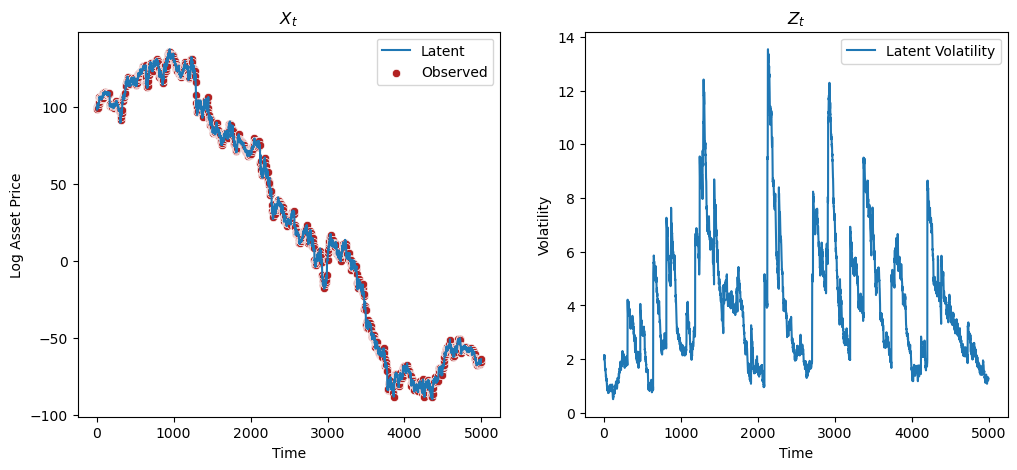

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey = False)

sns.lineplot(data= x_state[:,:,1].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[0],
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = tmp,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(title ="$X_t$");

# plt.plot(y_meas)
sns.lineplot(data= x_state[:,:,0].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[1],
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

In [13]:
n_part = 1000

multinom_pf = pf.particle_filter(
    theta=theta, 
    model=jdmodel, 
    y_meas=y_meas, 
    n_particles=n_part, 
    resampler=resampler.resample_multinomial,
    key=key,
    history = True)

In [14]:
multinom_pf["loglik"]

DeviceArray(-2177.898, dtype=float32)

In [15]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])


In [16]:
def neg_loglik(theta, y_meas, model, key, n_particles=100, resample_fn=resampler.resample_multinomial):
    """ negative log-likelihood of PF with continuous resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resample_fn,
        history = False)
    return -ret["loglik"]

def plot_particles (x_state, y_meas, vol_particles, price_particles, title=""):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex = True)
    fig.suptitle(title)

    sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
                 ax = ax[0],
                 label = "Latent")
    sns.scatterplot(x = "Time", y = "Log Asset Price", 
                    data = point_plot,
                    color = "firebrick",
                    ax = ax[0],
                    label="Observed").set(xlabel="Time",title ="$X_t$");

    sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
                 ax = ax[1],
                 label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

    for t in range(n_obs-1):
        for s in range(n_res):
            my_x = (t*n_res) + s
            sns.scatterplot(x = my_x, 
                            y=price_particles[t, :, s], 
                            s = 2, 
                            color = "green", ax = ax[0]);
            sns.scatterplot(x = my_x, 
                            y=vol_particles[t, :, s], 
                            s = 2, 
                            color = "green", ax = ax[1]);


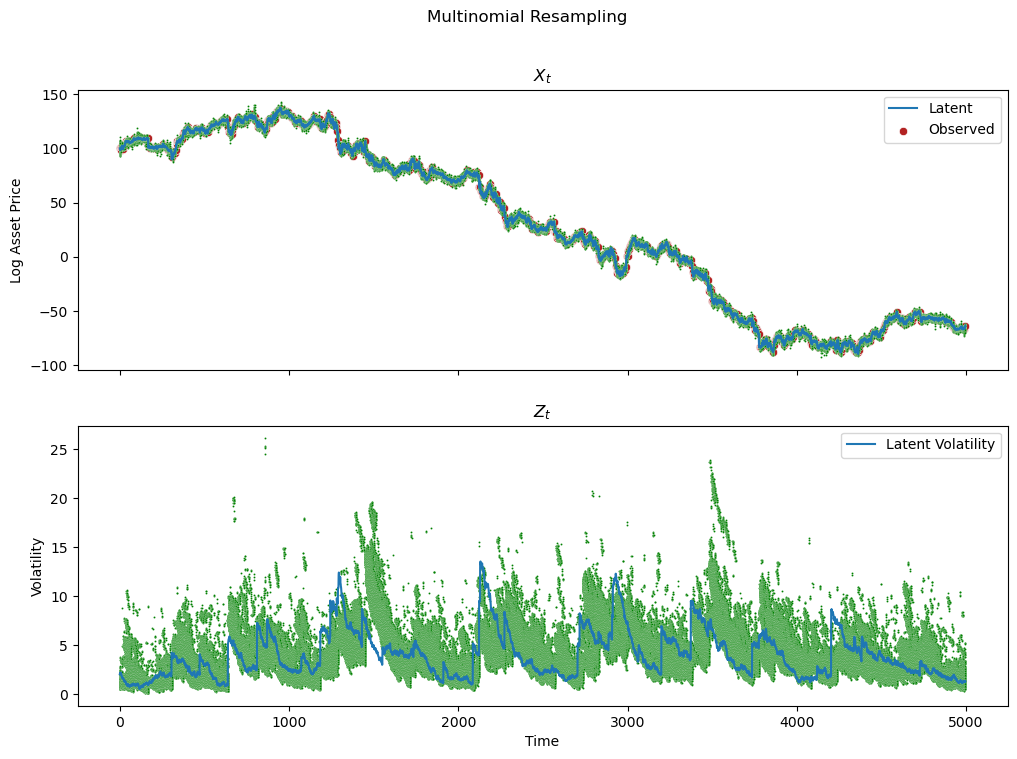

In [17]:
plot_particles(x_state, y_meas, 
               vol_particles=multinom_pf["x_particles"][1:, :, :, 0], 
               price_particles=multinom_pf["x_particles"][1:, :, :, 1],
               title = "Multinomial Resampling")

In [202]:
def particle_gibbs(key, model, n_iter, theta_init, x_state_init, n_particles, rw_sd):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    # initialize the sampler
    n_params = theta_init.size
    amwg = mcmc.AdaptiveMWG(adapt_max=0.0, adapt_rate=.1)
    # initial state of MWG sampler
    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": amwg.init(rw_sd),
    }

    def mcmc_update(key, theta, x_state, adapt_pars):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        keys = jax.random.split(key, num=3) # two for particle_filter, one for amwg
        # latent variable update
        pf_out = pf.particle_filter(
            model=model,
            key=keys[0],
            y_meas=y_meas,
            theta=theta,
            n_particles=n_particles,
            history=True
        )
        x_state = pf.particle_smooth(
            key=keys[1],
            logw=pf_out["logw"][y_meas.shape[0]-1],
            x_particles=pf_out["x_particles"],
            ancestors=pf_out["resample_out"]["ancestors"]
        )

        # parameter update
        def logpost(theta):
            """
            Log-posterior of the conditional parameter distribution.
            """
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            )
        theta_state, accept = amwg.step(
            key=keys[2],
            position=theta,
            logprob_fn=logpost,
            rw_sd=adapt_pars["rw_sd"]
        )
        # adapt random walk jump sizes
        adapt_pars = amwg.adapt(pars=adapt_pars, accept=accept)
        return theta_state, x_state, adapt_pars, accept

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    # calculate acceptance rate
    out["accept_rate"] = (1.0 * state["adapt_pars"]["n_accept"]) / n_iter
    return out

In [277]:
n_particles = 50
rw_sd = 0.001 * jnp.ones(8)
n_iter = 1000

key, subkey = jax.random.split(key)
pg_out = particle_gibbs(
    key=subkey, 
    model=jdmodel,
    n_iter=n_iter, 
    theta_init=theta, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    rw_sd=rw_sd
)

pg_out["accept_rate"] # should be close to 0.44

DeviceArray([0.998, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ], dtype=float32)

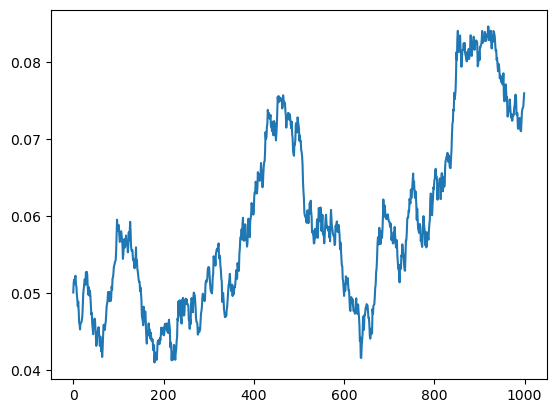

In [321]:
plt.plot(pg_out["theta"][:,4])

In [206]:
jnp.argwhere((pg_out["x_state"])[:,1:,3,2] != 0)

DeviceArray([[   0,   33],
             [   3,   74],
             [   4,   61],
             ...,
             [4999,   56],
             [4999,   57],
             [4999,   83]], dtype=int32)

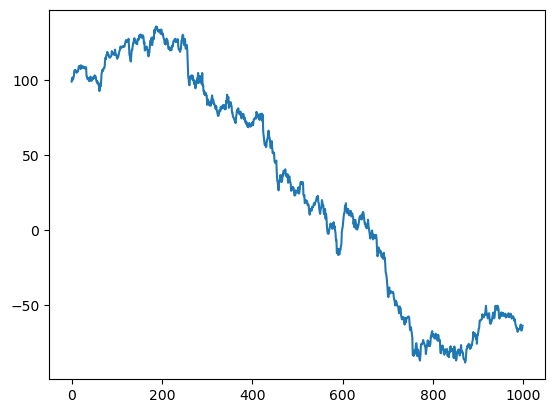

In [274]:
plt.plot((pg_out["x_state"])[n_iter,1:,3,0])

In [30]:
jnp.argwhere(jnp.isnan((pg_out["x_state"])[1000,:,:,:]))

DeviceArray([[21,  1,  0],
             [21,  2,  0],
             [21,  2,  1],
             ...,
             [99,  3,  0],
             [99,  3,  1],
             [99,  4,  0]], dtype=int32)

In [27]:
# plot data
plot_pg = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas),
                         "med": jnp.squeeze(jnp.median(pg_out["x_state"],axis=0)),
                         "2.5th": jnp.squeeze(jnp.percentile(pg_out["x_state"], 2.5, axis=0)),
                         "97.5th": jnp.squeeze(jnp.percentile(pg_out["x_state"], 97.5, axis=0))}))

g = sns.FacetGrid(plot_pg, height = 6)
g = g.map(plt.scatter, "time", "meas", color="grey")
plt.plot(plot_df['time'], plot_pg['state'], color='black')
plt.plot(plot_df['time'], plot_pg['med'], color='deepskyblue')

plt.fill_between(plot_df['time'], plot_pg['2.5th'], plot_pg['97.5th'], color='skyblue', alpha=0.5)

plt.legend(labels=["Measurement", "State: True", "State: Posterior Median"])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

ValueError: Data must be 1-dimensional

## Bridge (scratch)

This is essentially a different set of code from above...

In [28]:
def bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum, dt, n_res):
    k = n_res - n
    dt_res = dt/n_res
    
    mu_z = x[0] + (theta[1]+theta[2]*x[0])*dt_res + vz
    sig2_z = x[0]*(theta[3]**2)*dt_res
    
    mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
    sig2_x = (k - 1)/k*x[0]*dt_res
    
    return mu_z, sig2_z, mu_x, sig2_x

In [49]:
def bridge_step_lean(key, x_prev, y_curr, theta):
        
    def scan_fun(carry, t):
        key = carry["key"]
        x = carry["x"]
        
        n, vz, vx, vx_invcumsum = t
        mu_z, sig2_z, mu_x, sig2_x = bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum, dt, n_res)

        key, subkey1, subkey2 = random.split(key,3)
        
        x_prop = jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(subkey1),
                            jnp.where(n<n_res-1, 
                                      mu_x + jnp.sqrt(sig2_x) * random.normal(subkey2),
                                      y_curr),
                            vz, vx])

        lp_prop = jnp.where(n<n_res-1,
                            jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                            0.0)
        
        res_carry = {
            "x": x_prop,
            "key": key,
            "lp": carry["lp"] + lp_prop
        }

        res_stack = {"x": x_prop, "lp":lp_prop}

        return res_carry, res_stack
    
    scan_init = {
        "x": x_prev[n_res-1],
        "key": key,
        "lp": jnp.array(0.)
    }
    
    key, key_jump, key_z, key_x = random.split(key, 4)
    
    ns = jnp.arange(n_res)
    jumps = jax.random.bernoulli(key_jump, shape=(n_res,), p=theta[4]*dt/n_res)
    vzs = theta[7]*jax.random.exponential(key_z, shape=(n_res,))*jumps
    vxs = (theta[5]+theta[6]*jax.random.normal(key_x, shape=(n_res,)))*jumps
    vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
    
    last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))
    
    x_prop = full["x"]
    
    logw_trans = state_lpdf_lean(
        x_curr=x_prop,
        x_prev=x_prev, 
        theta=theta
    )
    
    logw = logw_trans - last["lp"]
    
    return x_prop, logw

In [50]:
def drift(x, theta):
    mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
    return mu

def diff(x, theta):
    Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
    return Sigma

def euler_lpdf_jump_lean(x_curr, x_prev, dt, drift, diff, theta):
    return jsp.stats.norm.logpdf(
        x=x_curr[1],
        loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3],
        scale=jnp.sqrt(diff(x_prev, theta)[1,1])
    ) 

def state_lpdf_lean(x_curr, x_prev, theta):
    x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
    x1 = x_curr
    lp = jax.vmap(lambda xp, xc:
                  euler_lpdf_jump_lean(
                      x_curr=xc, x_prev=xp,
                      dt=dt/n_res,
                      drift=drift,
                      diff=diff,
                      theta=theta))(x0, x1)
    return jnp.sum(lp)

In [51]:
Y =90.5
x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                    [jnp.array([2.0, 100.0,0.0,0.0])]])

In [52]:
bridge_step_lean(key, x_init, Y, theta)

(DeviceArray([[ 1.9730737, 98.72009  ,  0.       ,  0.       ],
              [ 1.9454038, 96.62436  ,  0.       ,  0.       ],
              [ 1.825615 , 94.16346  ,  0.       ,  0.       ],
              [ 1.7348462, 92.77914  ,  0.       ,  0.       ],
              [ 1.6930153, 90.5      ,  0.       ,  0.       ]],            dtype=float32),
 DeviceArray(-8.908953, dtype=float32))

In [33]:
sum([-0.7353262, -2.0758278, -2.245111 , -1.1401016, -2.7125864])

-8.908953